# Торговый бот
- Тренировка: фьючерсы сбера (SBRF), шаг - 1 час
- Тест: см. ниже

In [1]:
import tensorflow as tf
import numpy as np
from finta import TA
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import minmax_scale, normalize
import sys
import pylab
import numpy as np
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report

In [2]:
WINDOW_SIZE = 40
TRAIN_TEST_SPLIT = 0.97 # set to 0.1 for other stocks data testing

In [2]:
def preprocess(fname):
    df = pd.read_csv(fname)
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    #dfcopy = df.copy()
    indicators = df.copy()
    indicators['KAMA'] = TA.KAMA(df)
    indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    indicators['TEMA20'] = TA.TEMA(df, period=20)
    indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA50'] = TA.EMA(df, period=50)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    indicators['RSI5'] = TA.RSI(df, period=5)
    indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    indicators['ATR'] = TA.ATR(df)
    indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    
    dft = indicators.close - indicators.close.shift()
    dft.fillna(0, inplace=True)
    dft = dft.values
    signals = np.array([1 if i > 0 else 0 for i in dft])[:]
    dfcopy = indicators.close.values.copy()
    
    #indicators = normalize(indicators.values, axis=0, norm='max')
    dfcopy = np.array([dfcopy[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    data = np.array([
        normalize(indicators[i:i+WINDOW_SIZE].values, axis=0, norm='max')
        for i in range(len(indicators)-WINDOW_SIZE)])
    signals = np.array([signals[i+WINDOW_SIZE] for i in range(len(signals)-WINDOW_SIZE)])
    
    split_index = int(len(data)*TRAIN_TEST_SPLIT)
    data_train, signals_train = data[:split_index], signals[:split_index]
    data_test, signals_test, dfcopy = data[split_index:], signals[split_index:], dfcopy[split_index:]
    return data_train, signals_train, data_test, signals_test, dfcopy

#data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SBRF.csv')

In [24]:
i

,open,high,low,close,volume,KAMA,HMA,TEMA5,TEMA20,EMA25,...,RSI14,RSI5,RSI21,ATR,Bull.,Bear.,KST,signal,MACD,SIGNAL
53,38600.0,38600.0,37800.0,38191.0,641,37319.815814,38196.1,38501.089352,38363.729074,35043.835627,...,84.920809,79.827471,83.877742,776.500000,2046.894165,1246.894165,218.783433,233.188575,11204.079936,16869.211186
54,38000.0,38600.0,37895.0,38350.0,306,37637.922984,38321.2,38495.744975,38596.228148,35301.309643,...,85.804790,83.842022,84.487150,812.571429,1790.141611,1085.141611,214.094989,229.868360,10717.735175,15638.910230
55,38847.0,38847.0,38312.0,38312.0,22,37849.110380,38302.5,38423.730739,38753.766604,35535.549605,...,84.439748,78.258768,83.655850,811.571429,1822.511699,1287.511699,208.392110,226.262651,10684.230515,14647.970579
56,40000.0,41550.0,39300.0,41000.0,339,38996.177177,38543.8,40254.939097,39559.663175,35960.325165,...,93.230136,97.304523,90.743040,1000.000000,3957.494681,1707.494681,209.032241,223.161357,10244.792162,13767.332260
57,40900.0,43000.0,40700.0,42694.0,911,40488.814738,39303.0,42200.309795,40635.934885,36483.338763,...,95.201378,98.525541,92.882545,1109.285714,4678.614284,2378.614284,213.872753,220.801198,9274.941282,12868.851913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3570,17232.0,17232.0,15425.0,16300.0,164408,19172.798329,18389.4,16454.661687,16916.410595,21616.207582,...,27.285261,25.000212,27.379981,1871.571429,-2566.613795,-4373.613795,-219.843688,-130.448642,-359.533772,-169.556146
3571,16352.0,18037.0,15711.0,17860.0,541720,19063.777818,17381.1,17257.096185,16718.628057,21327.268538,...,38.965282,51.966801,36.617364,1986.357143,-1484.668967,-3810.668967,-239.321612,-148.517791,-606.331143,-256.911145
3572,17908.0,18812.0,17451.0,17520.0,583296,18949.860211,17124.8,17433.035802,16502.255495,21034.401727,...,37.452407,46.500775,35.533736,1993.714286,-423.716258,-1784.716258,-256.540434,-167.506258,-831.429980,-371.814912
3573,17450.0,17638.0,16753.0,17440.0,642297,18852.274228,17126.0,17475.769042,16337.278777,20757.909286,...,37.061737,44.836297,35.263636,1898.785714,-1341.185364,-2226.185364,-270.882924,-186.976493,-1030.566121,-503.565154


In [64]:
conv_size = data_train.shape[-1]
model = Sequential()
#model.add(Dropout(0.1, input_shape=(WINDOW_SIZE, 7)))
model.add(Reshape((WINDOW_SIZE, conv_size, 1), input_shape=(WINDOW_SIZE, conv_size)))
filters = 28
model.add(Conv2D(filters, (1, conv_size), padding='valid'))
model.add(ReLU())
model.add(Dropout(0.35))
model.add(Reshape((WINDOW_SIZE, filters)))
model.add(Conv1D(16, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(16, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(Dropout(0.3))
model.add(Conv1D(16, kernel_size=3))
model.add(ReLU())
model.add(MaxPooling1D())
model.add(BatchNormalization())
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4))
model.add(BatchNormalization())
model.add(Dense(4))
model.add(ReLU())
model.add(Dense(1, activation='hard_sigmoid'))

model.summary()
model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_10 (Reshape)         (None, 40, 23, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 1, 28)         672       
_________________________________________________________________
re_lu_73 (ReLU)              (None, 40, 1, 28)         0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 40, 1, 28)         0         
_________________________________________________________________
reshape_11 (Reshape)         (None, 40, 28)            0         
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 38, 16)            1360      
_________________________________________________________________
re_lu_74 (ReLU)              (None, 38, 16)          

In [60]:
model = Sequential()
conv_size = data_train.shape[-1]
model.add(Conv1D(16, kernel_size=3, input_shape=(WINDOW_SIZE, conv_size), padding='valid'))
model.add(ReLU())
model.add(MaxPool1D())
model.add(Conv1D(16, kernel_size=3, input_shape=(WINDOW_SIZE, conv_size), padding='valid'))
model.add(ReLU())
model.add(MaxPool1D())
model.add(BatchNormalization())
model.add(Conv1D(16, kernel_size=3, input_shape=(WINDOW_SIZE, conv_size), padding='same'))
model.add(ReLU())
#model.add(MaxPool1D())
model.add(CuDNNLSTM(4, return_sequences=True))
model.add(CuDNNLSTM(4, return_sequences=False))
model.add(BatchNormalization())
model.add(Flatten())
#model.add(Dense(16))
#model.add(ReLU())
model.add(Dense(4))
model.add(ReLU())
model.add(Dense(1, activation='hard_sigmoid'))

model.summary()
model.compile(optimizer=Adam(0.001, epsilon=1e-7), loss='binary_crossentropy', metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_43 (Conv1D)           (None, 38, 16)            1120      
_________________________________________________________________
re_lu_60 (ReLU)              (None, 38, 16)            0         
_________________________________________________________________
max_pooling1d_36 (MaxPooling (None, 19, 16)            0         
_________________________________________________________________
conv1d_44 (Conv1D)           (None, 17, 16)            784       
_________________________________________________________________
re_lu_61 (ReLU)              (None, 17, 16)            0         
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 8, 16)             0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 8, 16)           

In [97]:
conv_size

23

In [6]:
model = tf.keras.models.load_model('workingfull.h5')

W0331 02:17:31.959883  2320 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0331 02:17:31.968135  2320 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0331 02:17:31.971402  2320 deprecation.py:506] From C:\Users\Admin\.conda\envs\neuro\lib\site-packages\tensorflow\python\ops\init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) wit

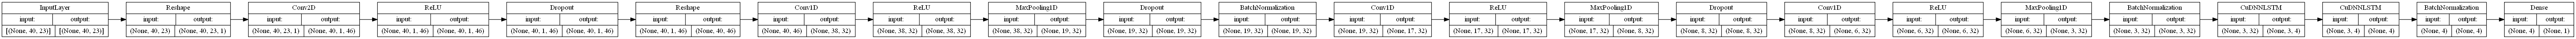

In [78]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False, rankdir='LR')

In [68]:
preds = model.predict(data_test)

In [69]:
preds

array([[0.54902565],
       [0.5488964 ],
       [0.54878503],
       [0.5486292 ],
       [0.54849875],
       [0.5484028 ],
       [0.5484182 ],
       [0.5485793 ],
       [0.54873157],
       [0.54855365],
       [0.54838157],
       [0.54842436],
       [0.5482791 ],
       [0.5482784 ],
       [0.5482572 ],
       [0.5483776 ],
       [0.5485694 ],
       [0.548568  ],
       [0.54848945],
       [0.5488231 ],
       [0.54882455],
       [0.54878044],
       [0.5487922 ],
       [0.5488975 ],
       [0.54890406],
       [0.54908735],
       [0.54861724],
       [0.21104053],
       [0.45385015],
       [0.43825412],
       [0.43031007],
       [0.4291198 ],
       [0.38406122],
       [0.38512188],
       [0.38200977],
       [0.37938857],
       [0.37820765],
       [0.3760844 ],
       [0.3737828 ],
       [0.37266997],
       [0.37786704],
       [0.4817989 ],
       [0.53760356],
       [0.5464785 ],
       [0.5438248 ],
       [0.54560214],
       [0.4546123 ],
       [0.513

In [98]:
model.fit(data_train, signals_train, shuffle=False, epochs=500, validation_data=(data_test, signals_test))

Train on 3377 samples, validate on 105 samples
Epoch 1/500
3377/3377 [==============================] - 4s 1ms/sample - loss: 0.7439 - acc: 0.5031 - val_loss: 0.6936 - val_acc: 0.4952
Epoch 2/500
3377/3377 [==============================] - 2s 636us/sample - loss: 0.7018 - acc: 0.5043 - val_loss: 0.6940 - val_acc: 0.4952.7014 - acc: 0.50
Epoch 3/500
3377/3377 [==============================] - 2s 660us/sample - loss: 0.6989 - acc: 0.4972 - val_loss: 0.6936 - val_acc: 0.4952
Epoch 4/500
3377/3377 [==============================] - 2s 648us/sample - loss: 0.6932 - acc: 0.5173 - val_loss: 0.6956 - val_acc: 0.4952
Epoch 5/500
3377/3377 [==============================] - 2s 714us/sample - loss: 0.6961 - acc: 0.5031 - val_loss: 0.6952 - val_acc: 0.4952
Epoch 6/500
3377/3377 [==============================] - 3s 758us/sample - loss: 0.6938 - acc: 0.5185 - val_loss: 0.6954 - val_acc: 0.4952
Epoch 7/500
3377/3377 [==============================] - 3s 781us/sample - loss: 0.6940 - acc: 0.5188 - 

KeyboardInterrupt: 

In [113]:
TRAIN_TEST_SPLIT = 1.0
data_train, signals_train, data_test, signals_test, dfcopy = preprocess('AFLT.csv')

In [116]:
data_test

array([], shape=(0, 40, 23), dtype=float64)

In [ ]:
### data_train, signals_train, data_test, signals_test, dfcopy = preprocess('AFLT.csv')
#model.fit(data_train, signals_train, shuffle=False, epochs=300, validation_data=(data_test, signals_test))
TRAIN_TEST_SPLIT = 0.9
#data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SPFB2.csv')
#model.fit(data_train, signals_train, shuffle=False, epochs=300)
#data_train, signals_train, data_test, signals_test, dfcopy = preprocess('GOLD.csv')
model.fit(data_train, signals_train, shuffle=False, epochs=300, validation_data=(data_test, signals_test))
#data_train, signals_train, data_test, signals_test, dfcopy = preprocess('AFLT.csv')
#model.fit(data_train, signals_train, shuffle=False, epochs=40)
#data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SBERD2.csv')
#model.fit(data_train, signals_train, shuffle=False, epochs=80)

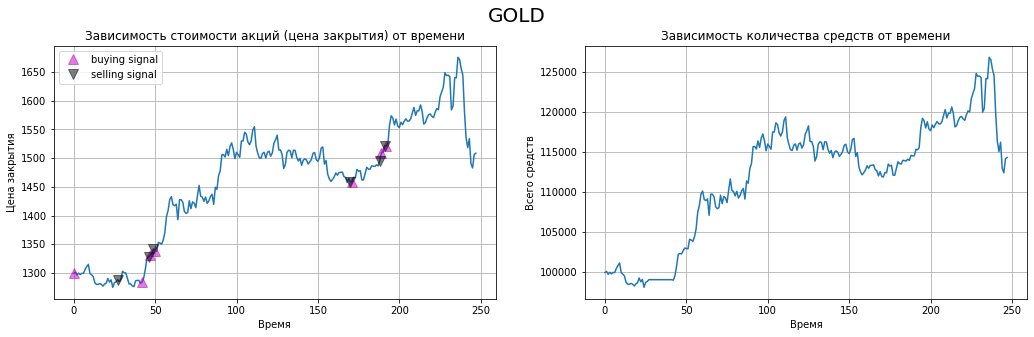

In [71]:
SURE = 0.0
model_test('GOLD', data_test, dfcopy)

In [127]:
model.save_weights('workingafltweightsnew.h5')
tf.keras.models.save_model(model, 'workingafltmodelnew.h5')

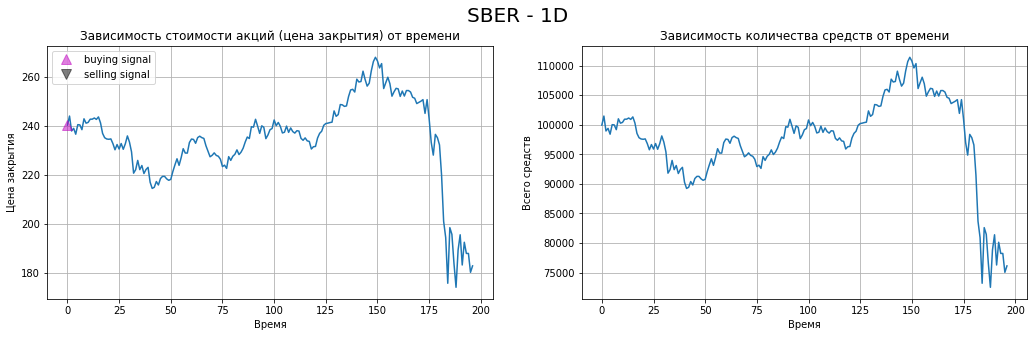

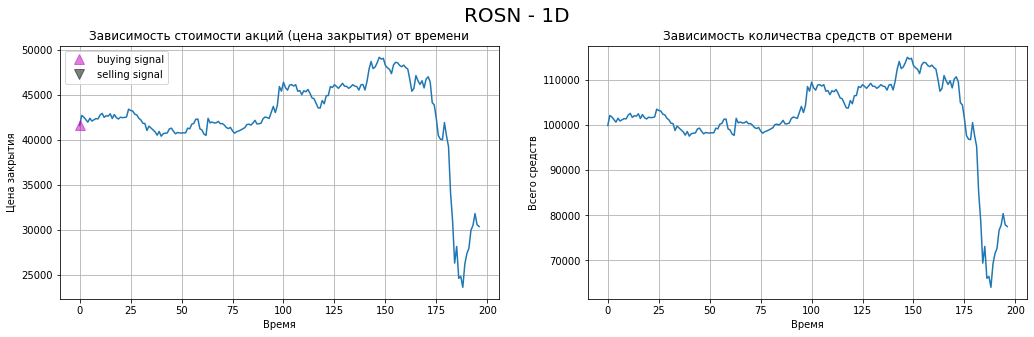

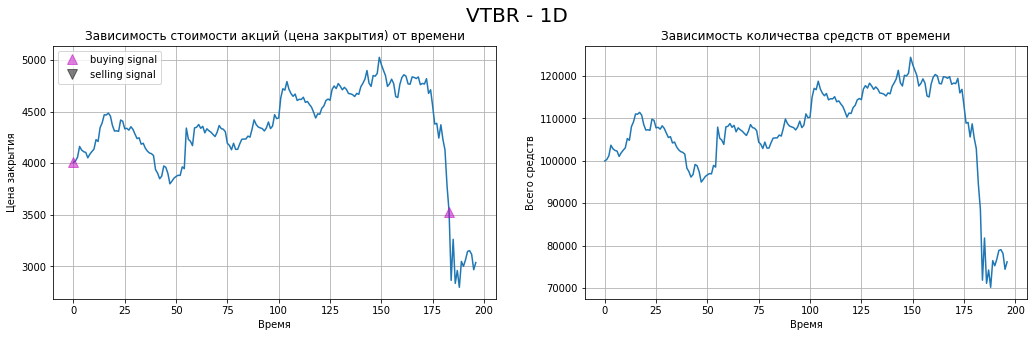

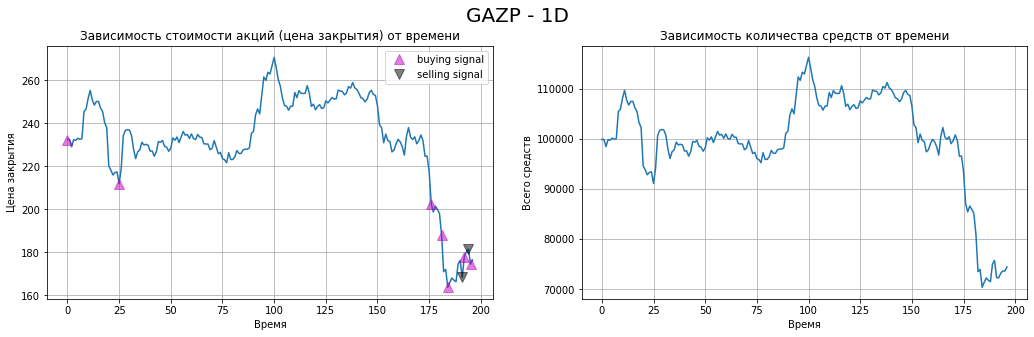

In [67]:
SURE = 0.0
params = [#('SBERH.csv', 'SBER - 1H'),
          ('SBERD.csv', 'SBER - 1D'),
          ('ROSN.csv', 'ROSN - 1D'),
          ('VTBR.csv', 'VTBR - 1D'),
          ('GAZPD.csv', 'GAZP - 1D'),
          #('GAZPH.csv', 'GAZP - 1H'),
         ]
TRAIN_TEST_SPLIT = 0.1
for p in params:
    automated_test(*p)
TRAIN_TEST_SPLIT = 0.97

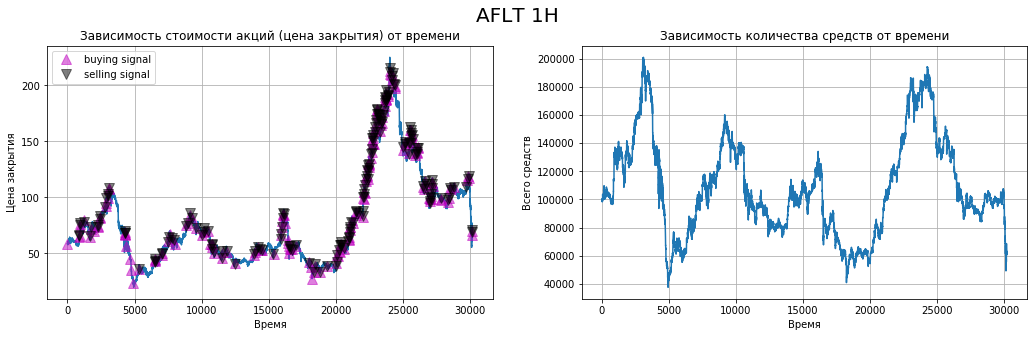

In [129]:
TRAIN_TEST_SPLIT = 0.1
automated_test('AFLTH.csv', 'AFLT 1H')
TRAIN_TEST_SPLIT = 0.97

In [17]:
SURE = 0.05
COMISSION = 0.05/100
BROKER_COMISSION = 10

def model_test(fname, data_test, dfcopy):
    sure = SURE
    money = 100000
    cur_stocks = 0

    sells = []
    buys = []
    stats = []

    preds = model.predict(data_test)
    temp_df = dfcopy.copy()
    #temp_df = temp_df[int(len(dfcopy)*TRAIN_TEST_SPLIT):].values
    for i, p in enumerate(preds):
        price = temp_df[i]
        if abs(p - 0.5) > sure:
            if p <= 0.5:
                if cur_stocks > 0:
                    sells.append(i)
                    money -= BROKER_COMISSION
                #n_stocks = money // price
                money += cur_stocks*price*(1-COMISSION)
                cur_stocks = 0
            else:
                n_stocks = money // price
                if n_stocks > 0:
                    buys.append(i)
                    money -= BROKER_COMISSION
                money -= n_stocks*price*(1+COMISSION)
                cur_stocks += n_stocks
        stats.append(price*cur_stocks + money)
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(fname, fontsize=20)
    axes[0].set_title("Зависимость стоимости акций (цена закрытия) от времени")
    axes[0].plot(temp_df)
    axes[0].plot(temp_df, '^', markersize=10, color='m', label = 'buying signal', markevery = buys, alpha=0.5)
    axes[0].plot(temp_df, 'v', markersize=10, color='k', label = 'selling signal', markevery = sells, alpha=0.5)
    #axes[0].plot(temp_df, '.', markersize=1, color='m', label = 'buying signal', markevery = buys, alpha=1)
    #axes[0].plot(temp_df, '.', markersize=1, color='k', label = 'selling signal', markevery = sells, alpha=1)
    axes[0].legend()
    axes[0].set_xlabel("Время")
    axes[0].set_ylabel("Цена закрытия")
    axes[0].grid()
    
    axes[1].set_title("Зависимость количества средств от времени")
    axes[1].plot(stats)
    axes[1].set_xlabel("Время")
    axes[1].set_ylabel("Всего средств")
    axes[1].grid()

    fig.tight_layout(pad=3)

In [19]:
def automated_test(fname, title):
    data_train, signals_train, data_test, signals_test, dfcopy = preprocess(fname)
    model_test(title, data_test, dfcopy)

# Тестирование
Спойлер: заработок есть, но везде - уход в минус из-за недавнего падения стоимости акций: нейросеть не смогла предсказать такое резкое падение. А должна ли она уметь предсказывать такое? Как?..
## Сеть, тренированная на 1Н SBRF данных
Сеть училась на данных с шагом 1 час

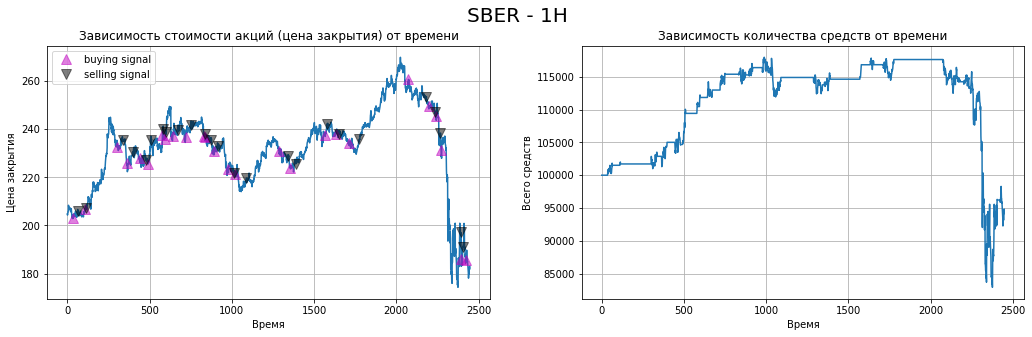

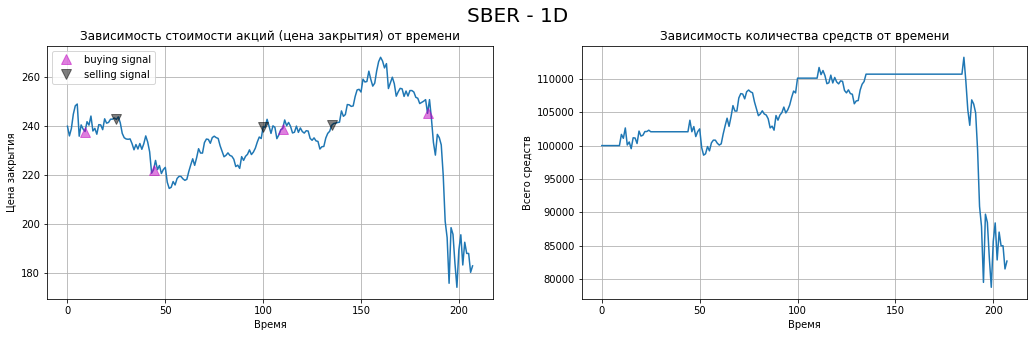

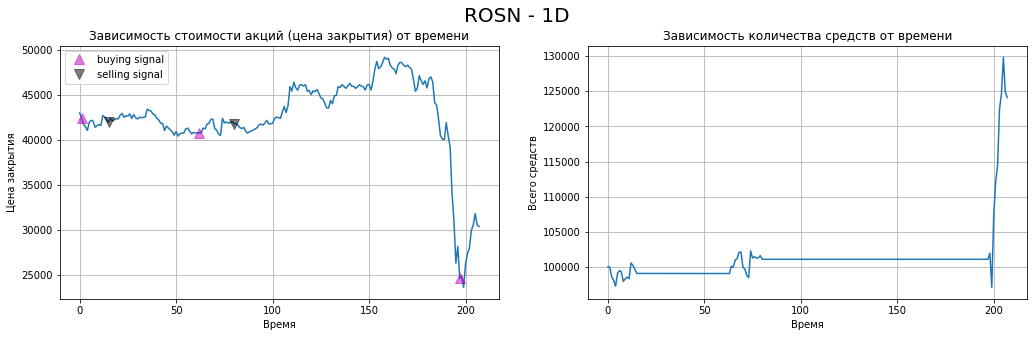

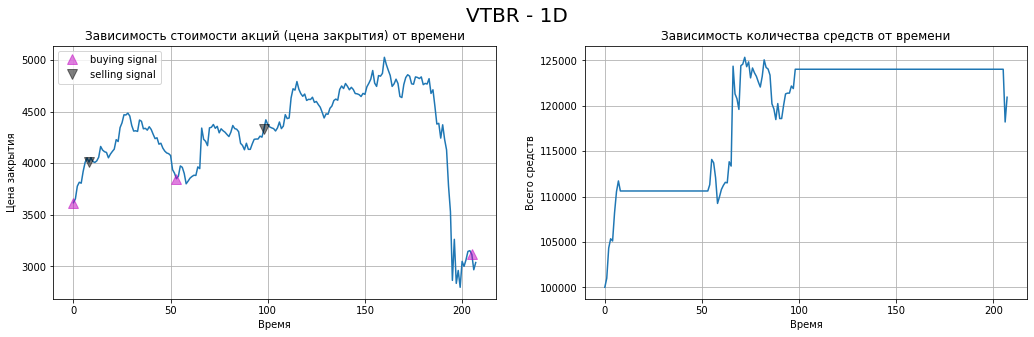

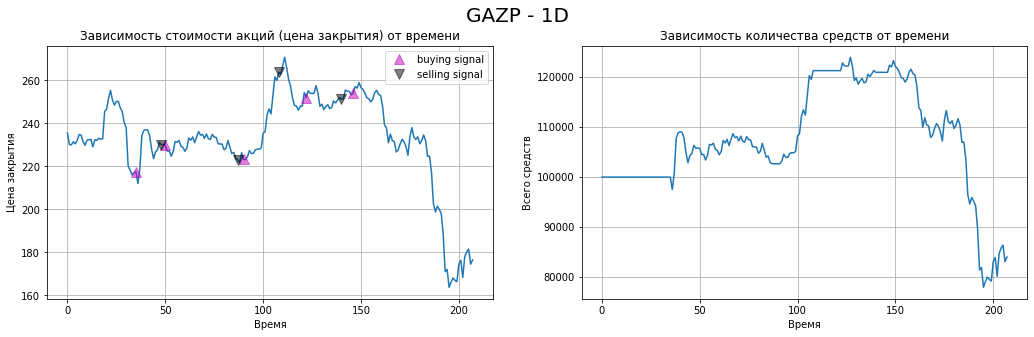

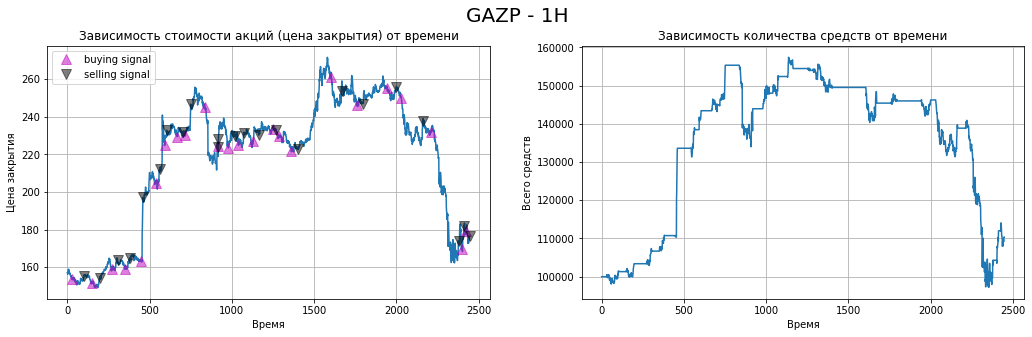

In [96]:
params = [('SBERH.csv', 'SBER - 1H'),
          ('SBERD.csv', 'SBER - 1D'),
          ('ROSN.csv', 'ROSN - 1D'),
          ('VTBR.csv', 'VTBR - 1D'),
          ('GAZPD.csv', 'GAZP - 1D'),
          ('GAZPH.csv', 'GAZP - 1H'),
         ]

for p in params:
    automated_test(*p)

## 1D AFLT + huge 1H AFLT
Сначала сеть училась с шагом в 1 день, затем дообучалась с шагом 1 час

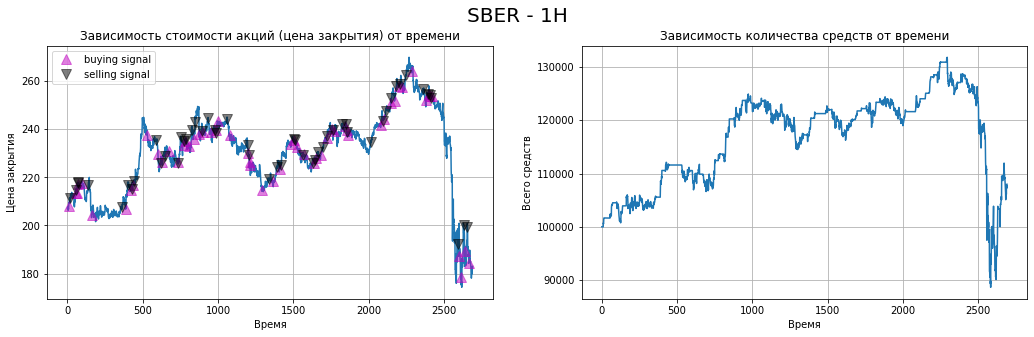

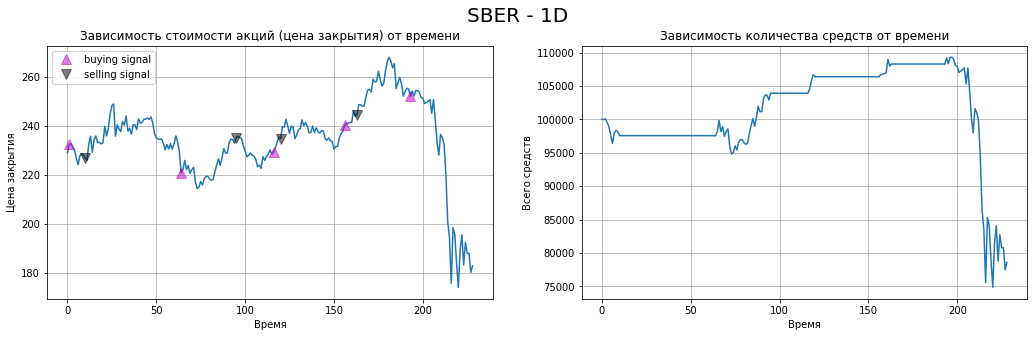

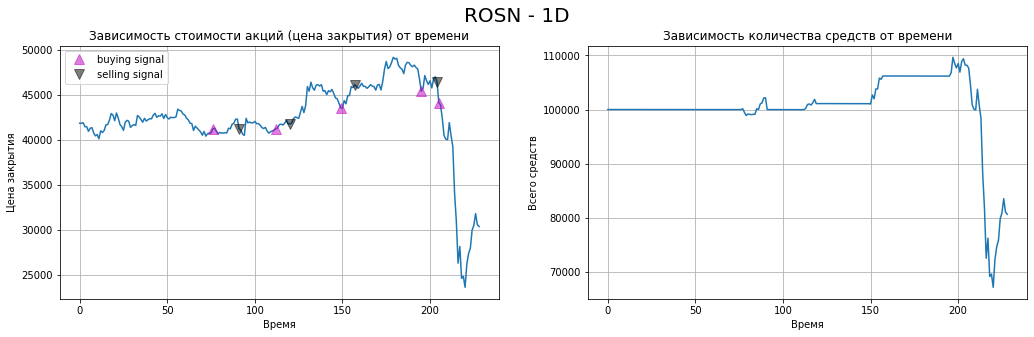

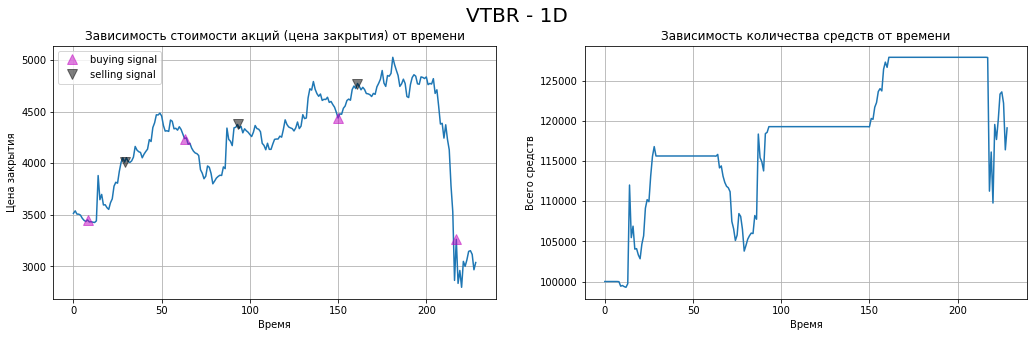

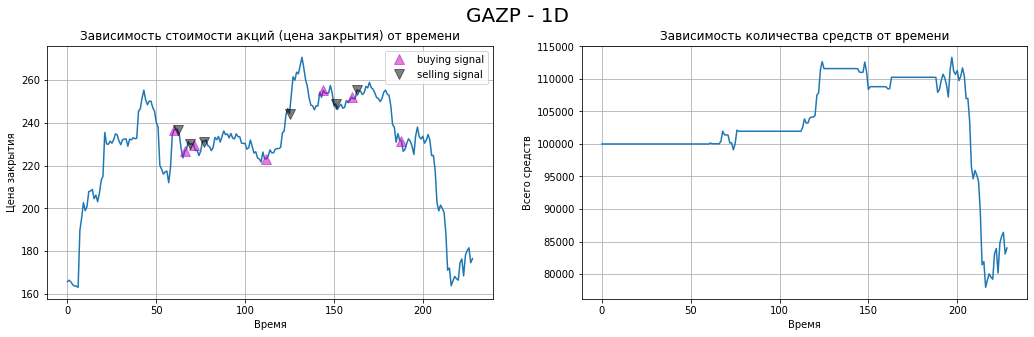

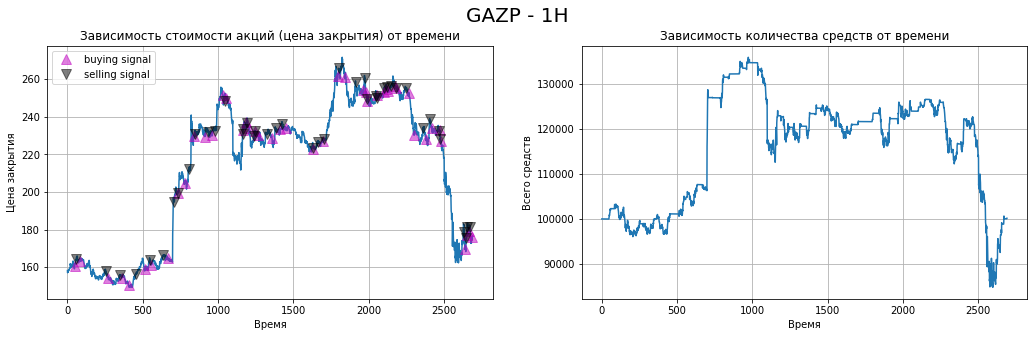

In [194]:
TRAIN_TEST_SPLIT = 0.01
params = [('SBERH.csv', 'SBER - 1H'),
          ('SBERD.csv', 'SBER - 1D'),
          ('ROSN.csv', 'ROSN - 1D'),
          ('VTBR.csv', 'VTBR - 1D'),
          ('GAZPD.csv', 'GAZP - 1D'),
          ('GAZPH.csv', 'GAZP - 1H'),
         ]

for p in params:
    automated_test(*p)
TRAIN_TEST_SPLIT = 0.97

### А можно ли заработать, если общий тренд - падение? Да:
(Это должно доказать, что есть "умная" и даже при падении рынка позволяет оставаться в плюсе)
Данные представлены ниже с **шагом в 1 час**

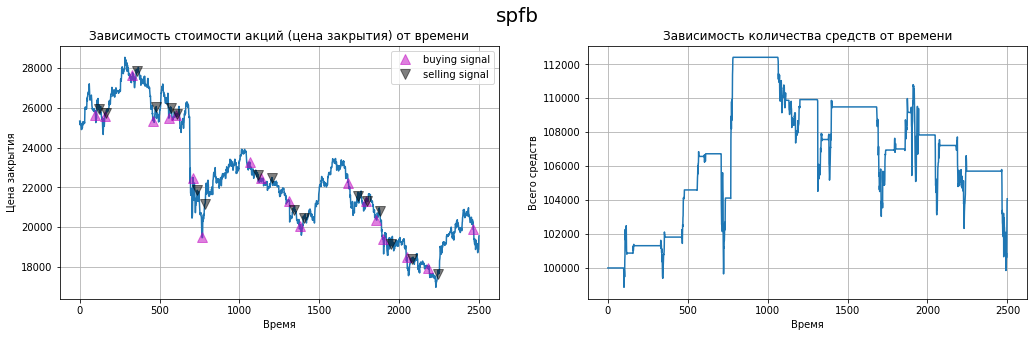

In [195]:
SURE = 0.1
TRAIN_TEST_SPLIT = 0.01
#df = pd.read_csv('SPFB2.csv')

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SPFB2.csv')
model_test('spfb', data_test[10500:13000], dfcopy[10500:13000])
TRAIN_TEST_SPLIT = 0.97

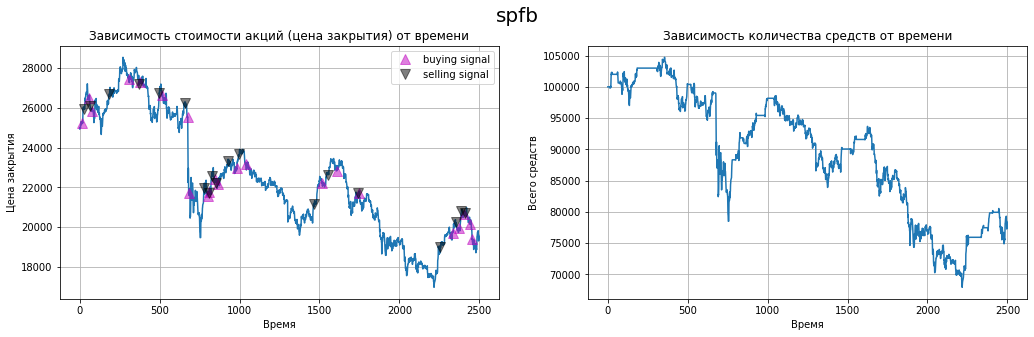

In [130]:
SURE = 0.1
TRAIN_TEST_SPLIT = 0.01
#df = pd.read_csv('SPFB2.csv')

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('SPFB2.csv')
model_test('spfb', data_test[10500:13000], dfcopy[10500:13000])
TRAIN_TEST_SPLIT = 0.97

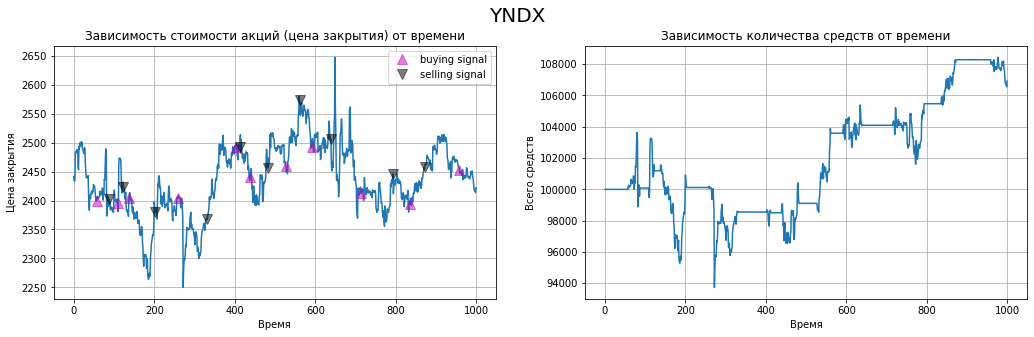

In [196]:
TRAIN_TEST_SPLIT = 0.01
#df = pd.read_csv('SPFB2.csv')

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('YNDX.csv')
model_test('YNDX', data_test[9500:10500], dfcopy[9500:10500])
TRAIN_TEST_SPLIT = 0.97

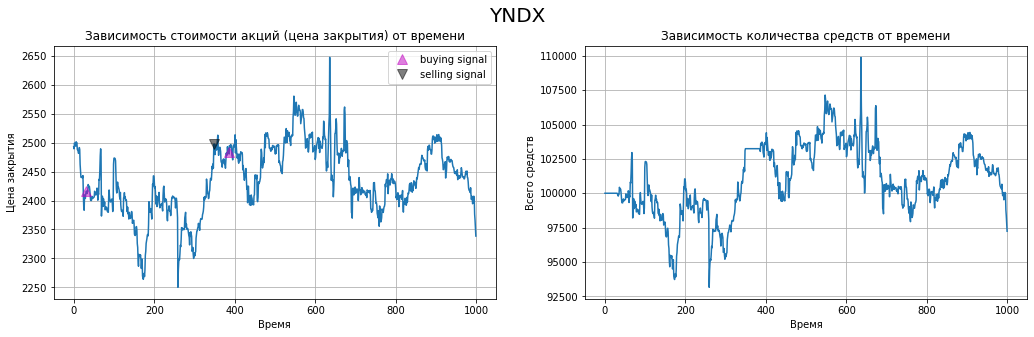

In [131]:
TRAIN_TEST_SPLIT = 0.01
#df = pd.read_csv('SPFB2.csv')

data_train, signals_train, data_test, signals_test, dfcopy = preprocess('YNDX.csv')
model_test('YNDX', data_test[9500:10500], dfcopy[9500:10500])
TRAIN_TEST_SPLIT = 0.97

# Вывод:
Обучив сеть на акциях одной компании, можно использовать её для торговли и другими акциями - видимо, у многих акций схожие паттерны.

In [3]:
def preprocess(fname):
    df = pd.read_csv(fname)
    if '<DATE>' in df: df.pop('<DATE>')
    if '<TIME>' in df: df.pop('<TIME>')
    
    df.columns = ['open', 'high', 'low', 'close', 'volume']
    #dfcopy = df.copy()
    indicators = df.copy()
    indicators['KAMA'] = TA.KAMA(df)
    indicators['HMA'] = TA.HMA(df)
    indicators['TEMA5'] = TA.TEMA(df, period=5)
    indicators['TEMA20'] = TA.TEMA(df, period=20)
    indicators['EMA25'] = TA.EMA(df, period=25)
    indicators['EMA50'] = TA.EMA(df, period=50)
    indicators['BBWIDTH'] = TA.BBWIDTH(df)
    indicators['AO'] = TA.AO(df)
    indicators['RSI14'] = TA.RSI(df)
    indicators['RSI5'] = TA.RSI(df, period=5)
    indicators['RSI21'] = TA.RSI(df, period=21)
    #indicators['STC'] = TA.STC(df)
    indicators['ATR'] = TA.ATR(df)
    indicators = indicators.assign(**TA.EBBP(df))
    indicators = indicators.assign(**TA.KST(df))
    indicators = indicators.assign(**TA.EV_MACD(df))
    indicators.dropna(inplace=True)
    
    
    return indicators

i = preprocess('SBRF.csv')

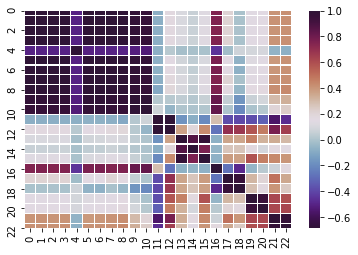

In [7]:
sns.heatmap(normalize(i.corr(), axis=0, norm='max'), cmap='twilight_shifted', linewidth=0.12)

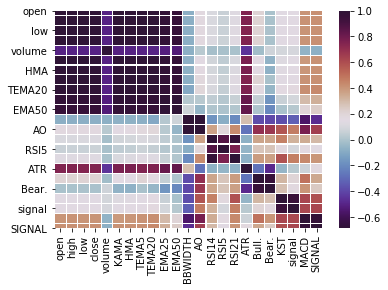

In [8]:
sns.heatmap(i.corr(), cmap='twilight_shifted', linewidth=0.12)

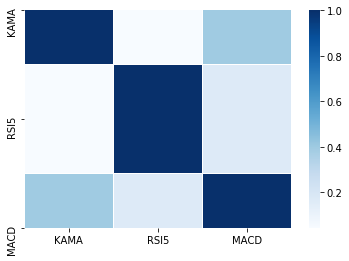

In [23]:
sns.heatmap(i[['KAMA', 'RSI5', 'MACD']].corr(), cmap='Blues', linewidth=0.12)